# **Response to mailings - Part 2 notebook**
In this notebook we evaluate several machine learning models and identify the best feature to predict mailings response 

# Table of contents

1. [Overview](#Overview)
2. [Data Processing](#Data_Understanding)
3. [Data Modelling](#Data_Modelling)
3. [Model Evaluation](#Model_Evaluation)
4. [Conclusion](#Conclusion)

# 1. Overview

In this notebook I will try and answer the following questions that could possible help the business to improve mailing campaigns:
* Can the response to mailings be predicted?
* Which features could be most important to the response?
* Can we identify an ideal mailing target individual?<br>

I will be using data modeling and feature engineering to prepare the data, where I will then evaluate different types of prediction models and pick the best one that performs will with the data.

<a id='Data_Understanding'></a>
# 2. Data processing: 
- features engineering
- encoding categorical features
- scaling numerical features

### Importing Libraries

In [66]:
# base
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
# models
import sklearn.ensemble
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb


# evaluation

from sklearn import feature_selection
from sklearn import model_selection

from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

from sklearn.model_selection import learning_curve, ShuffleSplit, StratifiedKFold

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV



### Loading Data

In [36]:
# Loading csv and pickle files into dataframe or list
df_mailings = pd.read_csv('data/population.csv')

In [37]:
# eliminate useless features
df_mailings = df_mailings.drop(['Unnamed: 0', 'label'], axis=1)

### Zip code feature grouping

In [38]:
df_mailings["zipcode_group"] = df_mailings['zip code']//10000

In [39]:
# show listings data sample
df_mailings.head(3)

,name,age,lifestyle,zip code,family status,car,sports,earnings,living area,response,zipcode_group
0,VnSEFOuL,62,cozily,50168,married,practical,athletics,102526,urban,0,5
1,8Tv0hcce,34,active,66479,married,expensive,soccer,33006,urban,0,6
2,Zny9ysbk,69,healthy,16592,single,expensive,badminton,118760,urban,1,1


### 2.2 One hot encoding:

encode categorical features


In [40]:
categorical_features = ['sports', 'lifestyle', "zipcode_group",'family status', 'car', 'living area']

In [41]:
def onehot_df(df, variables):
    
    """
    Creates one hot encoding for the specified columns
    using the unique items specified
    
    Parameters:
    
    Dataframe, variables(list of strings)
    
    Returns:
    
    Dataframe
    
    """
    
    for variable in variables: 
        # use pd.concat to join the new columns with your original dataframe
        df = pd.concat([df,pd.get_dummies(df[variable], prefix=variable)],axis=1)

# now drop the original variable column (you don't need it anymore)
        # Removing old column
        del df[variable]        
        # Return the results as a dataframe
    return df

In [42]:
df_encoded = onehot_df(df_mailings, categorical_features)

### 2.3 Scaling numerical features:

- age
- earnings


In [43]:
min_max_scaler = MinMaxScaler()
df_encoded[["age", "earnings"]] = min_max_scaler.fit_transform(df_encoded[["age", "earnings"]])

In [44]:
# Dropping unwanted columns
df_encoded = df_encoded.drop(['name', 'zip code'], axis=1)

In [45]:
df_encoded.head(10)

,age,earnings,response,sports_athletics,sports_badminton,sports_soccer,sports_unknown,lifestyle_active,lifestyle_cozily,lifestyle_healthy,...,zipcode_group_6,zipcode_group_7,zipcode_group_8,zipcode_group_9,family status_married,family status_single,car_expensive,car_practical,living area_rural,living area_urban
0,0.870370,0.634921,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,1
1,0.351852,0.100024,0,0,0,1,0,1,0,0,...,1,0,0,0,1,0,1,0,0,1
2,1.000000,0.759827,1,0,1,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,1
3,0.777778,0.857304,1,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,1
4,0.944444,0.584732,1,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,1
5,0.111111,0.487578,0,0,1,0,0,0,0,1,...,1,0,0,0,0,1,1,0,0,1
6,0.129630,0.229439,0,0,1,0,0,0,0,1,...,1,0,0,0,1,0,0,1,1,0
7,0.814815,0.162808,1,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,1
8,0.888889,0.879702,1,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1
9,0.296296,0.682386,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,1,0


<a id='Data_Modelling'></a>
## 3. Data Modeling

Now we are ready to train a model and predict the required solution. There are 60+ predictive modelling algorithms to choose from. We must understand the type of problem and solution requirement to narrow down to a select few models which we can evaluate. Our problem is a classification and regression problem. We want to identify relationship between output (response or not) with other variables or features (income, age, lifestyle...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning plus Classification and Regression, we can narrow down our choice of models to a few. These include:

    - Logistic Regression
    - KNN or k-Nearest Neighbors
    - Support Vector Machines
    - Naive Bayes Bernoulli classifier
    - Random Forest
    - XG-Boost
    - Perceptron



### 3.1 Identify target and predictors

In [46]:
# Extract features and labels
X = df_encoded.drop("response", axis=1) # drop labels for training set
y = df_encoded["response"].copy()

# List of features for later use
X_columns = list(X.columns)

#### Train / Test split

In [47]:
# Applying the train / test split 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)


In [48]:
# Confirming the rows and columns are the 
# same for train and test data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 24)
(2000, 24)
(8000,)
(2000,)


<a id='Model_Evaluation'></a>
## 4. Model evaluation

Compare results from several machine learning classification models

When it comes to data modeling, the beginner’s question is always, "what is the best machine learning algorithm?" To this the beginner must learn, the No Free Lunch Theorem (NFLT) of Machine Learning. In short, NFLT states, there is no super algorithm, that works best in all situations, for all datasets. So the best approach is to try multiple MLAs, tune them, and compare them for your specific scenario.


In [49]:
#Machine Learning Algorithm (MLA) Selection and Initialization
Dummy_frequent = DummyClassifier(random_state=0, strategy="most_frequent")# Dummy Classifier (baseline)
Logistic_Regression = LogisticRegression()
Bernoulli_Naive_Bayes = BernoulliNB() # naive Bayes algorithm for multinomially distributed data,
Support_Vector_Classifier = SVC()
Perceptron_Classifier = Perceptron()
Random_Forest = RandomForestClassifier()
KNN = KNeighborsClassifier(n_neighbors = 3)
XG_boost = xgb.XGBClassifier(objective='binary:logistic',random_state=42)

MLA = [Dummy_frequent,Logistic_Regression, Support_Vector_Classifier, Bernoulli_Naive_Bayes, Perceptron_Classifier, Random_Forest, KNN, XG_boost]

Now let's fit and obtain scores

In [50]:
def compare_classifiers(models_list):    
    MLA_names = []
    fit_times =[]
    acc_scores = []
    f1_scores = []
    precision_scores = []
    recall_scores = []
       
    for alg in MLA:
        MLA_name = alg.__class__.__name__
                
        #initiate time count
        global _start_time 
        start_time = time.time()
     
        alg.fit(X_train, y_train) # MLA fit
                
        y_pred = alg.predict(X_test) #MLA_predict
        # estimate time elapsed
        time_taken = round(((time.time() - start_time) / 60),3)
        #model scores  
        score = accuracy_score(y_test, y_pred)

        F1 = f1_score(y_test, y_pred)

        precision = precision_score(y_test, y_pred)

        recall = recall_score(y_test, y_pred)

        # add results to lists for a final comparison
        MLA_names.append(MLA_name)
        fit_times.append(time_taken)
        acc_scores.append(round(score, 2))
        precision_scores.append(round(precision, 2))
        recall_scores.append(round(recall, 2))
        f1_scores.append(round(F1, 2))
    
    #create table to compare MLA metrics
    MLA_columns = ['MLA Name', 'Fit_time', 'Accuracy', 'Precision', 'Recall', 'F1']
    zippedList =  list(zip(MLA_names, fit_times, acc_scores, f1_scores, precision_scores, recall_scores))
    df = pd.DataFrame(zippedList, columns = MLA_columns)
    return df

In [51]:
df_models = compare_classifiers(MLA)
df_models

/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,MLA Name,Fit_time,Accuracy,Precision,Recall,F1
0,DummyClassifier,0.000,0.64,0.00,0.00,0.00
1,LogisticRegression,0.001,0.81,0.70,0.78,0.63
2,SVC,0.030,0.83,0.75,0.80,0.71
3,BernoulliNB,0.000,0.67,0.29,0.61,0.19
4,Perceptron,0.000,0.68,0.24,0.83,0.14
5,RandomForestClassifier,0.009,0.89,0.85,0.84,0.86
6,KNeighborsClassifier,0.004,0.70,0.52,0.61,0.45
7,XGBClassifier,0.012,0.88,0.84,0.84,0.84


**Metrics importance**
We have thousands of customers reached by our mailings. We wish they would all respond, but it is imposible, so we are interested in those with good chances to be a buyer (respond to mailings). We don't care to email a false positive, i.e. a guy that is not going to buy (so precision is not important) but for us is very important that all of them with high temperature are always in my selection, so they don't go without responding and hopefully buying. That means that my model needs to have a high recall (as little false negatives as possible), no matter if the precision is conversely affected.

### 4.1 How do the best two models compare regarding efficiency? 

In [60]:
# "https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html"

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Accuracy score")
    axes[2].set_title("Performance of the model")

    return plt

#### Visualising Train and Test scores by the number of training points

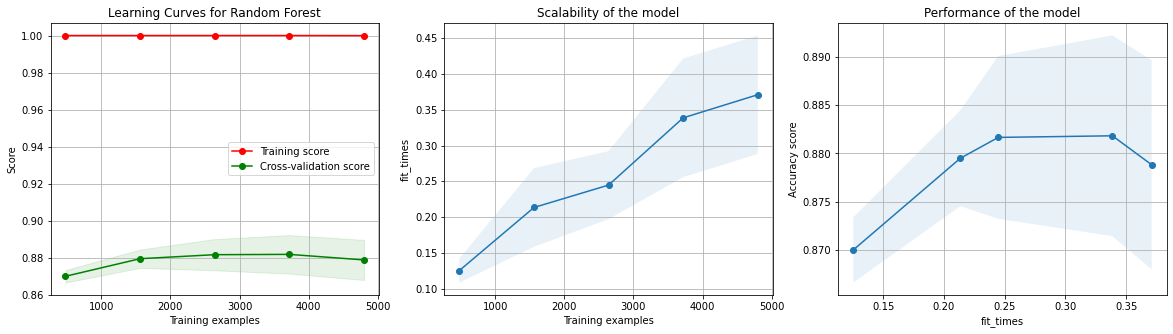

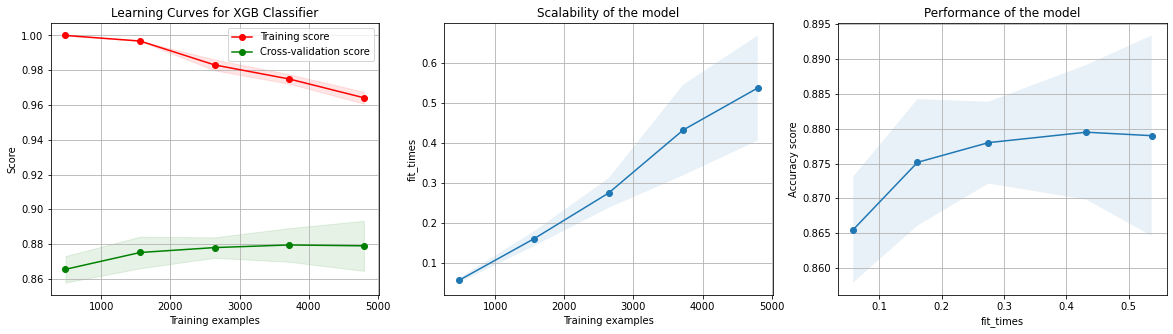

In [82]:
# Random Forest Classifier:
title = r"Learning Curves for Random Forest"
estimator = RandomForestClassifier()
plot_learning_curve(estimator, title,  X_train, y_train,cv=5, n_jobs=5)

# Xtreme Gradient Boosting Classifier:
title = r"Learning Curves for XGB Classifier"
estimator= xgb.XGBClassifier(objective= 'binary:logistic')
plot_learning_curve(estimator, title,  X_train, y_train,cv=5, n_jobs=5)

plt.show()

## 4.2 Fine tuning the best model

In [54]:
# define functions to measure time, to estimate our search efficiency
def process_time_starts():
    global _start_time 
    _start_time = time.time()

def time_elapsed():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('The process took: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [76]:
# Applying RandomizedSearchCV on the Random Forest Classifier algorithm

 # create training and validation dataset
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)


# Here we go
process_time_starts() # timing starts from this point 

randF = RandomizedSearchCV(Random_Forest, hyperF, cv = 3, verbose = 1, n_jobs = -1)
randF.fit(X_train, y_train)

time_elapsed() # timing ends here for the parameters search


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.5s finished


The process took: 0hour:0min:15sec


Next we set up our stratified folds and grid search parameters. I am using AUC as a scoring function, since we saw earlier that recall is quite important in this case.

Bit too long to read all results above. Let's print the grid-search results and save them in a file.

In [77]:
print('\n Best score:')
print(randF.best_score_)
print('\n Best hyperparameters:')
print(randF.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('data/RF-grid-search-results-01.csv', index=False)



 Best score:
0.8925000000000001

 Best hyperparameters:
{'n_estimators': 1200, 'min_samples_split': 100, 'min_samples_leaf': 5, 'max_depth': 8}


## 4.3 Feature Importance

In [78]:
# Final model and parameters
bestF = randF.best_estimator_
bestF

RandomForestClassifier(max_depth=8, min_samples_leaf=5, min_samples_split=100,
                       n_estimators=1200)

In [79]:
# get scores for the test set

y_pred = bestF.predict(X_test)

acc = accuracy_score(y_test, y_pred)

F1 = f1_score(y_test, y_pred)

precision = precision_score(y_test, y_pred)

recall = recall_score(y_test, y_pred)

print('accuracy:',acc, 'precision:',precision ,'recall:', recall, 'F1:', F1)

accuracy: 0.8915 precision: 0.8701492537313433 recall: 0.8176718092566619 F1: 0.8430947216196674


In [80]:
# feature importance scores
list_pc_importance = (bestF.feature_importances_)*100
feat = X.columns.tolist()
df_features = pd.DataFrame({'Feature':feat, '% weight': list_pc_importance}).sort_values(by=['% weight'], ascending = False )

#print(xgb2.feature_importances_)
df_features

,Feature,% weight
0,age,64.851182
1,earnings,25.060935
9,zipcode_group_1,6.679013
12,zipcode_group_4,0.285139
17,zipcode_group_9,0.253486
15,zipcode_group_7,0.220366
11,zipcode_group_3,0.212267
8,lifestyle_healthy,0.181148
16,zipcode_group_8,0.178906
13,zipcode_group_5,0.160342


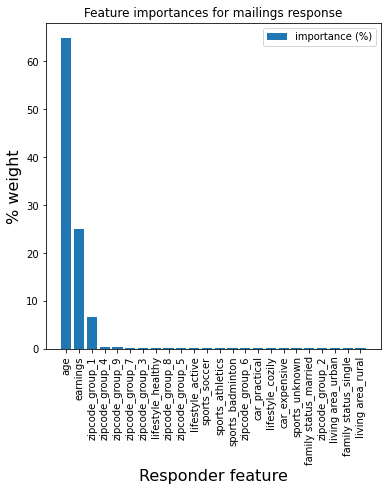

In [81]:
#plot graph of feature importances for better visualization
plt.figure(figsize= (6,6))
plt.title("Feature importances for mailings response")

plt.bar(df_features["Feature"], df_features["% weight"], label = 'importance (%)')

plt.legend()
plt.ylabel('% weight',fontsize = 16)
plt.xlabel('Responder feature',fontsize = 16)
plt.xticks(rotation=90)
plt.show()

<a id='Conclusion'></a>
# 5. Conclusion

With my final investigation I wanted to see if I could predict how likely someone is going to respond to mailings based on personal informations.

I found that the prediction model that performed the best, was the "Xtreme Gradient Boost" algorithm. I could predict response with a 90% accuracy on test data, and most important with 87% recall. This means I can have only very few false negatives and target the most likely responders.

When I investigated the features of the results, I found that the conclusions are very similar to those from simple EDA.
Main predictors are age, income and whether the target lives or not in the postcode area 10000 - 19999 (New York state in US). The sport and lifestyle are very minor predictors (less than 1% importance)